# 预训练word2vec
:label:`sec_word2vec_pretraining`

我们继续实现 :numref:`sec_word2vec`中定义的跳元语法模型。然后，我们将在PTB数据集上使用负采样预训练word2vec。首先，让我们通过调用`d2l.load_data_ptb`函数来获得该数据集的数据迭代器和词表，该函数在 :numref:`sec_word2vec_data`中进行了描述。


In [1]:
import math
import torch
from torch import nn
# from d2l import torch as d2l

import sys
sys.path.append("..")
import d2lzh_pytorch.torch as d2l

In [2]:
batch_size = 512
max_window_size = 5
num_noise_words = 5


data_iter, vocab = d2l.load_data_ptb(batch_size, 
                                     max_window_size,
                                     num_noise_words
                                    )

In [3]:
len(vocab)

6719

## 跳元模型

我们通过嵌入层和批量矩阵乘法实现了跳元模型。首先，让我们回顾一下嵌入层是如何工作的。




### 嵌入层

如 :numref:`sec_seq2seq`中所述，嵌入层将词元的索引映射到其特征向量。该层的权重是一个矩阵，其行数等于字典大小（`input_dim`），列数等于每个标记的向量维数（`output_dim`）。在词嵌入模型训练之后，这个权重就是我们所需要的。

In [5]:

embed = nn.Embedding(num_embeddings=20, embedding_dim=4)


In [29]:

print(embed.weight.shape)
print('')
print(embed.state_dict())

torch.Size([6719, 100])

OrderedDict([('weight', tensor([[ 0.4761,  0.1128, -1.0222,  ..., -0.5152, -0.8902, -0.8411],
        [ 0.3722, -0.2751, -0.4904,  ..., -0.4603,  0.2947,  0.3161],
        [-0.7959,  0.9478, -1.1439,  ..., -0.6314,  0.1573, -0.7545],
        ...,
        [-2.4556,  0.5651,  0.9982,  ...,  0.3764,  0.5220,  0.7389],
        [-1.2119, -0.6065,  0.1194,  ...,  1.4715, -0.4336, -1.2719],
        [-1.1923,  1.3760,  2.3172,  ...,  0.4887,  0.5520, -0.5506]]))])


嵌入层的输入是词元（词）的索引。对于任何词元索引$i$，其向量表示可以从嵌入层中的权重矩阵的第$i$行获得。由于向量维度（`output_dim`）被设置为4，因此当小批量词元索引的形状为（2，3）时，嵌入层返回具有形状（2，3，4）的向量。


In [36]:

def test_embed():

    # 输入索引, 输出向量
    x = torch.tensor([[1, 2, 3], [4, 5, 6]])


    a = embed(x)

    print(a.shape)  # torch.Size([2, 3, 100])
    print(a)

    
# test_embed()

### 定义前向传播

在前向传播中，跳元语法模型的输入包括形状为（批量大小，1）的中心词索引`center`和形状为（批量大小，`max_len`）的上下文与噪声词索引`contexts_and_negatives`，其中`max_len`在 :numref:`subsec_word2vec-minibatch-loading`中定义。这两个变量首先通过嵌入层从词元索引转换成向量，然后它们的批量矩阵相乘（在 :numref:`subsec_batch_dot`中描述）返回形状为（批量大小，1，`max_len`）的输出。输出中的每个元素是中心词向量和上下文或噪声词向量的点积。


In [8]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

让我们为一些样例输入打印此`skip_gram`函数的输出形状。


In [9]:

skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), 
          embed, 
          embed
         ).shape

torch.Size([2, 1, 4])

## 训练

在训练带负采样的跳元模型之前，我们先定义它的损失函数。



### 二元交叉熵损失

根据 :numref:`subsec_negative-sampling`中负采样损失函数的定义，我们将使用二元交叉熵损失。


In [10]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(inputs, 
                                                             target,
                                                             weight=mask,
                                                             reduction="none")
        return out.mean(dim=1)

    
loss = SigmoidBCELoss()

回想一下我们在 :numref:`subsec_word2vec-minibatch-loading`中对掩码变量和标签变量的描述。下面计算给定变量的二进制交叉熵损失。


In [11]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])


loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

下面显示了如何使用二元交叉熵损失中的Sigmoid激活函数（以较低效率的方式）计算上述结果。我们可以将这两个输出视为两个规范化的损失，在非掩码预测上进行平均。


In [12]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### 初始化模型参数

我们定义了两个嵌入层，将词表中的所有单词分别作为中心词和上下文词使用。字向量维度`embed_size`被设置为100。


In [25]:
embed_size = 100


# 将词元的索引映射到其特征向量
embed = nn.Embedding(num_embeddings=len(vocab), 
                     embedding_dim=embed_size)

# 网络构建
net = nn.Sequential(embed,
                    embed
                   )

### 定义训练阶段代码

训练阶段代码实现定义如下。由于填充的存在，损失函数的计算与以前的训练函数略有不同。


In [20]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
            
    net.apply(init_weights)
    net = net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', 
                            ylabel='loss', 
                            xlim=[1, num_epochs])
    
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)

    timer = d2l.Timer()
    for epoch in range(num_epochs):
        num_batches = len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            
            pred = skip_gram(center, context_negative, net[0], net[1])
            
            l = (loss(pred.reshape(label.shape).float(), 
                      label.float(), 
                      mask) / mask.sum(axis=1) * mask.shape[1])
            
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
                
        timer.stop()

    print('Time consuming: %s s' % timer.final_time())
    print('耗时区间: %s s' % timer.interval_consume())
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

现在，我们可以使用负采样来训练跳元模型。


Time consuming:   7.9783 s
耗时区间: ['1.5731', '1.5747', '1.5579', '1.6162'] s
loss 0.661, 214882.0 tokens/sec on cuda:0


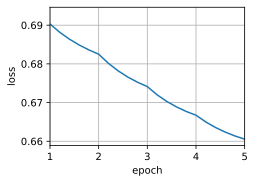

In [21]:
lr = 0.002
num_epochs = 5


# 开始训练
train(net, data_iter, 
      lr, 
      num_epochs
     )

## 应用词嵌入
:label:`subsec_apply-word-embed`

在训练word2vec模型之后，我们可以使用训练好模型中词向量的余弦相似度来从词表中找到与输入单词语义最相似的单词。


In [22]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    
    # 删除输入词
    for i in topk[1:]:  
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

In [23]:

get_similar_tokens('chip', 3, net[0])

cosine sim=0.469: intel
cosine sim=0.395: bugs
cosine sim=0.379: mips


In [24]:

get_similar_tokens('fake', 4, net[0])

cosine sim=0.378: nor
cosine sim=0.372: legislature
cosine sim=0.356: earthquake
cosine sim=0.336: tradition


In [35]:

query_token = 'final'


W = embed.weight.data
x = W[vocab[query_token]]

In [33]:
x.shape

torch.Size([100])

In [34]:
x

tensor([ 0.4756,  1.3037, -1.5622, -1.7664,  0.0787,  0.8455,  1.3392,  0.8508,
        -1.2539, -0.9761,  0.1725,  1.4941, -0.0461, -1.4089, -1.2133, -0.1351,
         1.0198,  0.9928,  0.3512, -0.0202,  0.4322, -0.4794, -1.5700, -1.5993,
         1.0088,  0.6259, -0.1362,  0.0793, -0.5678,  0.8742, -0.5235,  0.0894,
        -0.6346,  0.4666,  0.7447,  0.7660, -0.4090, -1.2032, -0.7996,  0.3739,
        -0.7044, -0.6704, -0.4886, -0.1921,  0.1967, -0.4475, -2.1991,  1.5410,
         0.2482,  1.7091, -0.3208, -0.0884, -0.7176,  0.6046,  0.1356, -0.4676,
        -0.7229, -0.1451,  0.4663,  0.9185, -0.5874, -1.2846, -0.7890, -1.5818,
        -0.6478, -1.3336, -1.4572,  0.2908,  0.1168, -0.1663,  0.6142, -1.4681,
        -0.7127, -0.1187,  0.9364, -0.2296,  0.9428,  0.3961,  0.1154,  1.4969,
        -1.9043, -0.9254, -0.2987,  1.2063, -1.1563,  0.1156, -0.1099,  0.5777,
         0.9876,  1.5581, -0.1470,  0.7276, -1.2493,  0.3402,  0.3949, -1.7197,
         1.7332,  1.7071,  1.8112, -0.85

## 小结

* 我们可以使用嵌入层和二元交叉熵损失来训练带负采样的跳元模型。
* 词嵌入的应用包括基于词向量的余弦相似度为给定词找到语义相似的词。